# Tau PT Regression Notebook

In this notebook we will implement a NN to regress the tau's transverse momentum.

In [5]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib
from keras import optimizers


import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=500)])
    except RuntimeError as e:
        print(e)

model_name = '../models/pt_regress_v1.h5'

# Create training/testing data set

The important aspect of $\tau$ leptons is that a $\tau$ can decay to neutrinos, and either an electron and a neutrino, a muon and a neutrino, or quarks. Electrons, muons and quarks can be reconstructed in a collider detector. However, the neutrinos cannot. Neutrinos are very weakly interacting and they will just escape the detector. 

The one constraint we have for neutrinos is what we call missing transverse energy. Missing transverse energy is a constraint that originates from the fact that when we collider protons along a specific axis, the momentum transverse to that axis is conserved, or in other words. 

$$
\begin{equation}
\sum_{i=1}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} + \sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = 0 \\
\sum_{i= {\rm neutrino}}^{N}\vec{p_{T,i}} = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\rm{\vec{MET}}  = -\sum_{i\neq {\rm neutrino}}^{N}\vec{p_{T,i}} \\
\end{equation}
$$

This is what we call the MET or missing transverse energy. This is our only constraint on the neutrinos and it gives us a vector in the plane perpendicular to the collision axis along the beam.  

Here, instead of training directly for the tau's gen (truth) pT, we want to train for the ratio between the reconstructed pT and the gen pT. This is because the range of pT is so large that it makes training very uneffective. If we train for the ratio, we constrain the output better and the network is more likely to converge. It is also unitless, which means that if there is an invrance against momentum, like lorentz invariance, we can capture it in this quantity  

A technical detail here is the fact that the tau gen $p_T$ here does not include the neutrino's $p_T$.

In [6]:
#You only need to run this once
def create_train_test_data(dir_path):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    
    inputs = data['ntuplePupSingle']['tree']['m_inputs'].array()
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    #Inputs: pt, eta, phi, particle id(one hot encoded)
    X = np.nan_to_num(np.asarray(inputs[selection]))
    y = truth_pt[selection]/reco_pt[selection]
    
    indices = np.arange(X.shape[0])
    
    #X_train[abs(X_train) > 1e+9] = 0.
    
    #Split to training/testing data
    X_train, X_test, y_train, y_test, idx_train, idx_test  = train_test_split(X, y, indices, test_size=0.33, random_state=42)

    np.save(dir_path+"/X_train.npy", X_train)
    np.save(dir_path+"/X_test.npy", X_test)
    
    np.save(dir_path+"/y_train.npy", y_train)
    np.save(dir_path+"/y_test.npy", y_test)
    
    np.save(dir_path+"/idx_train.npy", idx_train)
    np.save(dir_path+"/idx_test.npy", idx_test)

In [7]:
create_train_test_data("../../ntuples/Jan_25_2023")

In [8]:
X_train = np.load("../../ntuples/Jan_25_2023/X_train.npy")
X_test = np.load("../../ntuples/Jan_25_2023/X_test.npy")

y_train = np.load("../../ntuples/Jan_25_2023/y_train.npy")
y_test = np.load("../../ntuples/Jan_25_2023/y_test.npy")

idx_train = np.load("../../ntuples/Jan_25_2023/idx_train.npy")
idx_test = np.load("../../ntuples/Jan_25_2023/idx_test.npy")

## Model

In [9]:
model = Sequential()

model.add(Dense(25,
                input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))

model.add(Dense(25,
                input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))

model.add(Dense(10,
                input_shape=X_train.shape[1:],
                activation= 'LeakyReLU'))

model.add(Dense(1))

2023-06-02 13:04:28.043872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
opt = keras.optimizers.Adam()
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                2025      
                                                                 
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dense_2 (Dense)             (None, 10)                260       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,946
Trainable params: 2,946
Non-trainable params: 0
_________________________________________________________________


In [11]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    verbose=2,
                    validation_split=0.20,
                    callbacks=[callback])

Epoch 1/20
707/707 - 2s - loss: 0.6889 - val_loss: 0.2421 - 2s/epoch - 3ms/step
Epoch 2/20
707/707 - 1s - loss: 0.2343 - val_loss: 0.2110 - 1s/epoch - 2ms/step
Epoch 3/20
707/707 - 1s - loss: 0.2123 - val_loss: 0.1978 - 1s/epoch - 2ms/step
Epoch 4/20
707/707 - 1s - loss: 0.1987 - val_loss: 0.1783 - 1s/epoch - 2ms/step
Epoch 5/20
707/707 - 1s - loss: 0.1899 - val_loss: 0.1698 - 1s/epoch - 2ms/step
Epoch 6/20
707/707 - 1s - loss: 0.1856 - val_loss: 0.1745 - 1s/epoch - 2ms/step
Epoch 7/20
707/707 - 1s - loss: 0.1805 - val_loss: 0.1600 - 1s/epoch - 2ms/step
Epoch 8/20
707/707 - 1s - loss: 0.1782 - val_loss: 0.1784 - 1s/epoch - 2ms/step
Epoch 9/20
707/707 - 2s - loss: 0.1762 - val_loss: 0.1555 - 2s/epoch - 2ms/step
Epoch 10/20
707/707 - 2s - loss: 0.1748 - val_loss: 0.1688 - 2s/epoch - 2ms/step
Epoch 11/20
707/707 - 1s - loss: 0.1726 - val_loss: 0.1682 - 1s/epoch - 2ms/step
Epoch 12/20
707/707 - 1s - loss: 0.1713 - val_loss: 0.1552 - 1s/epoch - 2ms/step
Epoch 13/20
707/707 - 1s - loss: 0.16

In [12]:
#Save the model
model.save(model_name)

-----

## Evaluate the model 

So now that we trained for the ratio, let's plot it on the testing set!

In [ ]:
#model = load_model(model_name)

In [13]:
y_pred = model.predict(X_test)

1740/1740 [==============================] - 2s 925us/step


(0.0, 4.0)

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


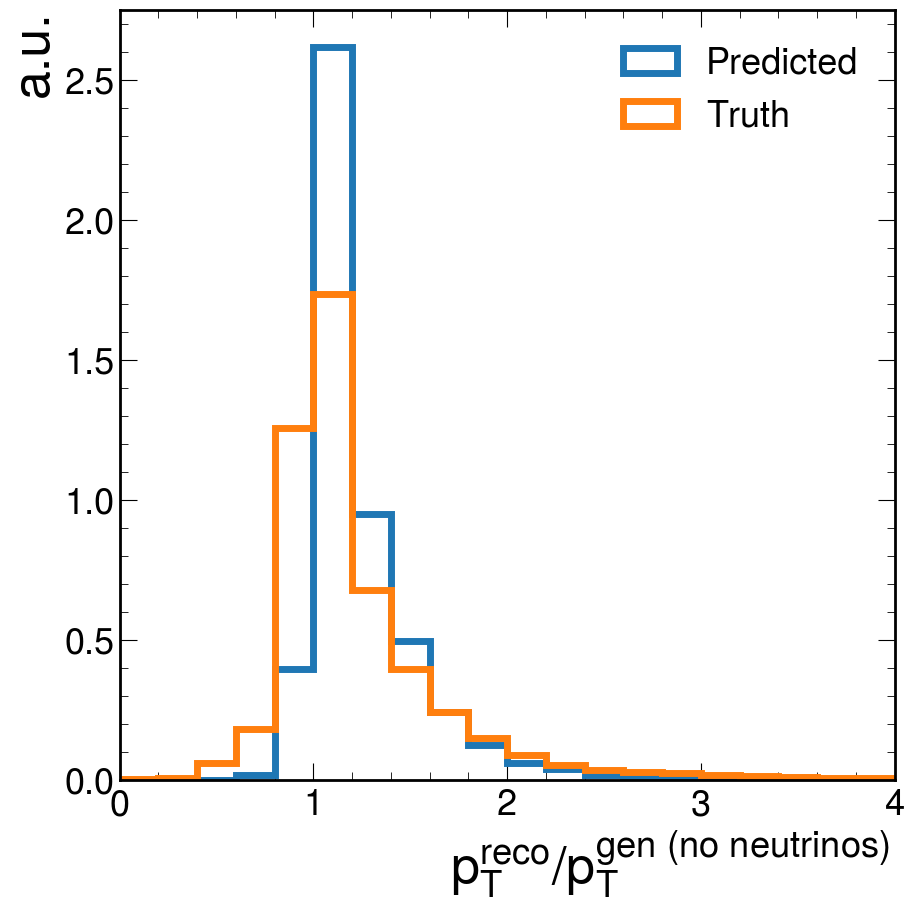

In [14]:
plt.hist(y_pred, bins = 20, range = (0,4), density=True, histtype = 'step', label = 'Predicted', linewidth=5)
plt.hist(y_test, bins = 20, range = (0,4), density=True, histtype = 'step', label = 'Truth', linewidth=5)

plt.xlabel(r'$p^{reco}_T/p^{gen~(no~neutrinos)}_T$ ')
plt.ylabel('a.u.')
plt.legend()
plt.xlim([0,4])

**Now compare the truth pT distribution and the predicted distribution (just multiply it by the ratio)**

In [15]:
#Load the pts and then plot the actual distributions

In [52]:
def load_and_predict_test(dir_path, model):
    
    #Might have to change the version for other ntuple files
    data = uproot4.open(dir_path+"/test_sig_v12_emseed.root")
    X_test = np.load(dir_path+"/X_test.npy")
    idx_test = np.load(dir_path+"/idx_test.npy")
    
    truth_pt = data['ntuplePupSingle']['tree']['genpt1'].array()
    reco_pt = data['ntuplePupSingle']['tree']['pt'].array()
    deltaR = data['ntuplePupSingle']['tree']['gendr1'].array()
    eta = data['ntuplePupSingle']['tree']['geneta1'].array()

    selection = (reco_pt > 0.) & (abs(deltaR) < 0.4) & (abs(eta) < 2.4)
    
    truth_pt_selected = np.asarray(data['ntuplePupSingle']['tree']['genpt1'].array()[selection][idx_test])
    reco_pt_selected = data['ntuplePupSingle']['tree']['pt'].array()[selection][idx_test]
    
    y_pred = model.predict(X_test).flatten()
    pred_pt = np.multiply(truth_pt_selected, y_pred)
    
    print(truth_pt)
    print(y_pred)
    print(pred_pt)
    
    #Plot the pts
    plt.hist(truth_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Truth', linewidth=5)
    plt.hist(reco_pt_selected, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'Reconstructed', linewidth=5)
    plt.hist(pred_pt, bins = 20, range = (0,300), density=True, histtype = 'step', label = 'NN Predicted', linewidth=5)

    plt.xlabel(r'$p_T$ [GeV]')
    plt.ylabel('a.u.')
    plt.legend()  
    plt.show()

1740/1740 [==============================] - 2s 1ms/step
[88, 0, 10.6, 0, 36.9, 0, 53.6, 0, 19.1, ... 0, 6.17, 73.7, 31.9, 0, 42.6, 0, 0, 0]
[1.0583348 1.2124062 1.1558751 ... 1.087915  1.2405139 1.0575554]
[ 49.971447  53.65557   53.00793  ...  36.42953   38.79472  123.06423 ]


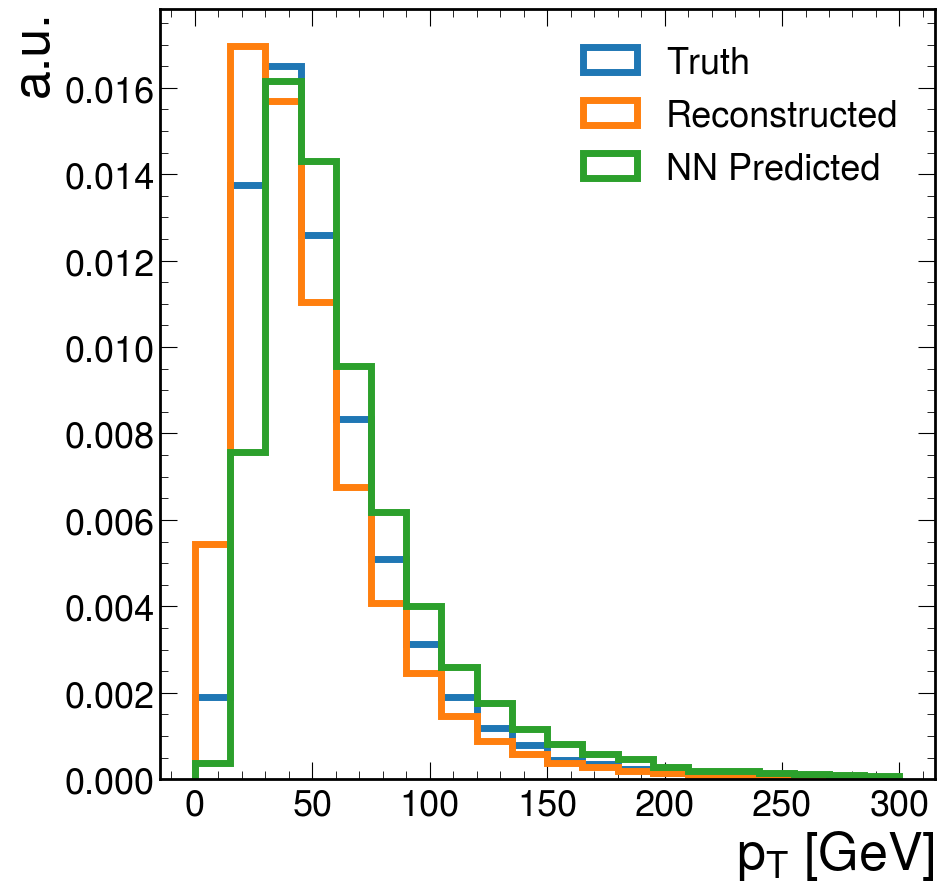

In [53]:
load_and_predict_test("../../ntuples/Jan_25_2023", model)